In [1]:
!pip install rasterio

In [43]:
import azureml.core
from azureml.core import Experiment, Workspace, Dataset, Datastore, ScriptRunConfig, Model
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
import os
import shutil
import glob
from os.path import join
import tensorflow as tf
from tensorflow.python.keras import models
from sys import path
import numpy as np
import rasterio as rio
import json

# check core SDK version number

print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.28.0


In [44]:
# attach our utilities folder to the path to import modules
path.append('/home/azureuser/cloudfiles/code/Users/mevans/Wetland_UNet/azure/scv')

In [45]:
from utils.model_tools import get_binary_model, make_confusion_matrix, weighted_bce
from utils.processing import get_training_dataset, normalize
from utils.prediction_tools import make_pred_dataset, make_array_predictions, write_geotiff_prediction

In [46]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
# get metadata about the workspace
print(ws.name, ws.location, ws.resource_group, sep='\t')
# list the registered datastores
ws.datastores

wetlands	eastus	cic_ai


{'workspaceartifactstore': {
   "name": "workspaceartifactstore",
   "container_name": "azureml",
   "account_name": "wetlands2489098639",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'wetlanddatastore': {
   "name": "wetlanddatastore",
   "container_name": "data",
   "account_name": "wetlands2489098639",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspacefilestore': {
   "name": "workspacefilestore",
   "container_name": "azureml-filestore-2640f222-8801-40ec-b413-83a7ec003a55",
   "account_name": "wetlands2489098639",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspaceblobstore': {
   "name": "workspaceblobstore",
   "container_name": "azureml-blobstore-2640f222-8801-40ec-b413-83a7ec003a55",
   "account_name": "wetlands2489098639",
   "protocol": "https",
   "endpoint": "core.windows.net"
 }}

In [47]:
# access our registered data share containing image data in this workspace
datastore = Datastore.get(workspace = ws, datastore_name = 'wetlanddatastore')

train_path = (datastore, 'seasonal/training/')
eval_path = (datastore, 'seasonal/eval/')

aoi = 'aoi_LES_entire'
# aoi = 'greenbury'
test_path = (datastore, f'seasonal/predict/{aoi}')

train_dataset = Dataset.File.from_files(path = [train_path])
eval_dataset = Dataset.File.from_files(path = [eval_path])
test_dataset = Dataset.File.from_files(path = [test_path])

In [48]:
experiment_name = 'wetland-unet-predict'
exp = Experiment(workspace = ws, name = experiment_name)

In [7]:
run_id = 'wetland-unet-seasonal_1652735695_493f1fdb'

run = ws.get_run(run_id)

run.tags

model_name = 'wetland-unet-seasonal-full'

In [8]:
# alternatively, get our model and weights file from a run
runFiles = run.get_file_names()
runFiles
run.download_files(prefix = 'outputs/', output_directory = run_id)

In [11]:
%cd ..
root = !pwd
model_dir = f'{root[0]}/{run_id}/outputs'
weight_path = glob.glob(os.path.join(model_dir, '*.hdf5'))
weight_path

/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans


['/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans/wetland-unet-les_1648737274_0520f70d/outputs/best_weights_31Mar22_06.hdf5',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans/wetland-unet-les_1648737274_0520f70d/outputs/best_weights_31Mar22_08.hdf5',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans/wetland-unet-les_1648737274_0520f70d/outputs/best_weights_31Mar22_13.hdf5',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans/wetland-unet-les_1648737274_0520f70d/outputs/best_weights_31Mar22_27.hdf5',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans/wetland-unet-les_1648737274_0520f70d/outputs/best_weights_31Mar22_33.hdf5',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans/wetland-unet-les_1648737274_0520f70d/outputs/best_weights_31Mar22_36.hdf5']

In [29]:
# if we haven't already registered our model
model = run.register_model(model_name= model_name,
                           tags=run.tags,
                           description = 'UNET model delineating wetlands using Sentinel-2, NAIP, lidar, geomorphon data from LES, MN, NY, DE.',
                           model_path='outputs/',
                           model_framework = 'Tensorflow',
                           model_framework_version= '2.0',
                           datasets = [('training', train_dataset), ('evaluation', eval_dataset), ('testing', test_dataset)])
print(model.name, model.id, model.version, sep='\t')

wetland-unet-seasonal-full	wetland-unet-seasonal-full:2	2


In [30]:
# get our model and weights files if the model has been registered
model_dir = Model.get_model_path(model_name, _workspace = ws)
weight_path = glob.glob(os.path.join(model_dir, '*.hdf5'))
weight_path[-1]

'azureml-models/wetland-unet-seasonal-full/2/outputs/best_weights_16May22_65.hdf5'

In [49]:
# Define some global variabes

# specify surface layers
lidar = ['lidar_intensity']
geomorphon = ["geomorphons"]

# Specify inputs (Sentinel bands) to the model
opticalBands = ['B3', 'B4', 'B5', 'B6']
thermalBands = ['B8', 'B11', 'B12']
senBands = opticalBands + thermalBands

# get band names for three seasons
seasonalBands = [[band+'_summer', band + '_fall', band + '_spring'] for band in senBands]

# specify NAIP bands
naipBands = ['R', 'G', 'B', 'N']

# BANDS = [item for sublist in seasonalBands for item in sublist] + naipBands# + lidar + geomorphon
RESPONSE = 'wetland'
# FEATURES = BANDS + [RESPONSE]
# ONE_HOT = {'geomorphons':11}

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
# DEPTH = len(BANDS)#+sum(ONE_HOT.values())-len(ONE_HOT.values())
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

METRICS = {
    'logits':[tf.keras.metrics.MeanSquaredError(name='mse'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
    'classes':[tf.keras.metrics.MeanIoU(num_classes=2, name = 'mean_iou')]
    }

In [32]:
if 'wlidar' in model_name:
    BANDS = [item for sublist in seasonalBands for item in sublist] + naipBands + lidar
    ONE_HOT = None
    DEPTH = len(BANDS)
    SPLITS = [21,4,1]
    name = 'wlidar'
elif 'wgeomorphon' in model_name:
    BANDS = [item for sublist in seasonalBands for item in sublist] + naipBands + geomorphon
    ONE_HOT = {'geomorphons':11}
    DEPTH = len(BANDS)+sum(ONE_HOT.values())-len(ONE_HOT.values())
    SPLITS = [21,4]
    name = 'wgeomorphon'
elif 'full' in model_name:
    BANDS = [item for sublist in seasonalBands for item in sublist] + naipBands + lidar + geomorphon
    ONE_HOT = {'geomorphons':11}
    DEPTH = len(BANDS)+sum(ONE_HOT.values())-len(ONE_HOT.values())
    SPLITS = [21,4,1]
    name = 'full'
else:
    BANDS = [item for sublist in seasonalBands for item in sublist] + naipBands
    ONE_HOT = None
    DEPTH = len(BANDS)
    SPLITS = [21,4]
    name = 'basic'

In [33]:
def get_weighted_bce(y_true,y_pred):
  return weighted_bce(y_true, y_pred, 1)
# m = models.load_model('azureml-models/wetland-unet-basic/5/outputs/unet256.h5', custom_objects = {'get_weighted_bce': get_weighted_bce})
m = get_binary_model(depth = DEPTH, optim = OPTIMIZER, loss = get_weighted_bce, mets = METRICS, bias = None)
# basic model
# m.load_weights('azureml-models/wetland-unet-basic/5/outputs/best_weights_23Jun21.hdf5')
# wlidar model
m.load_weights(weight_path[-1])
# # wgeomorphon model
# m.load_weights('azureml-models/wetland-unet-wgeomorphon/2/outputs/best_weights_25Jun21.hdf5')
# # full model
# m.load_weights('azureml-models/wetland-unet-full/2/outputs/best_weights_24Jun21.hdf5')

In [34]:
# Create mountcontext and mount the dataset
with test_dataset.mount() as test_mount:

    # Get the mount point
    dataset_mount_folder = test_mount.mount_point
    print(dataset_mount_folder)

    # for root, dirs, files in os.walk(dataset_mount_folder):
    #     for f in files:
    #         testFiles.append(join(root, f))

    predFiles = glob.glob(os.path.join(dataset_mount_folder, '*.gz'))
    jsonFile = glob.glob(os.path.join(dataset_mount_folder, '*.json'))[0]
    # jsonFile.download('')
    with open(jsonFile) as f:
        mixData = json.load(f)
    predData = make_pred_dataset(predFiles, BANDS, one_hot = ONE_HOT, splits = SPLITS)
    iterator = iter(predData)
    print(iterator.next())

    preds = make_array_predictions(imageDataset = predData, model = m, jsonFile = jsonFile)

/tmp/tmp_d7j38gb
Downloaded path: /tmp/tmpwaj29z5m/cf6b1359-0cf3-4b9b-8149-0d69a0840b35/seasonal/predict/test_aoi_Kumar_LES/raw_unet256_test_aoi_Kumar_LESmixer.json is different from target path: /tmp/tmpwaj29z5m/cf6b1359-0cf3-4b9b-8149-0d69a0840b35/raw_unet256_test_aoi_Kumar_LESmixer.json
Downloaded path: /tmp/tmpwaj29z5m/cf6b1359-0cf3-4b9b-8149-0d69a0840b35/seasonal/predict/test_aoi_Kumar_LES/raw_unet256_test_aoi_Kumar_LES00000.tfrecord.gz is different from target path: /tmp/tmpwaj29z5m/cf6b1359-0cf3-4b9b-8149-0d69a0840b35/raw_unet256_test_aoi_Kumar_LES00000.tfrecord.gz
tf.Tensor(
[[[[ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0

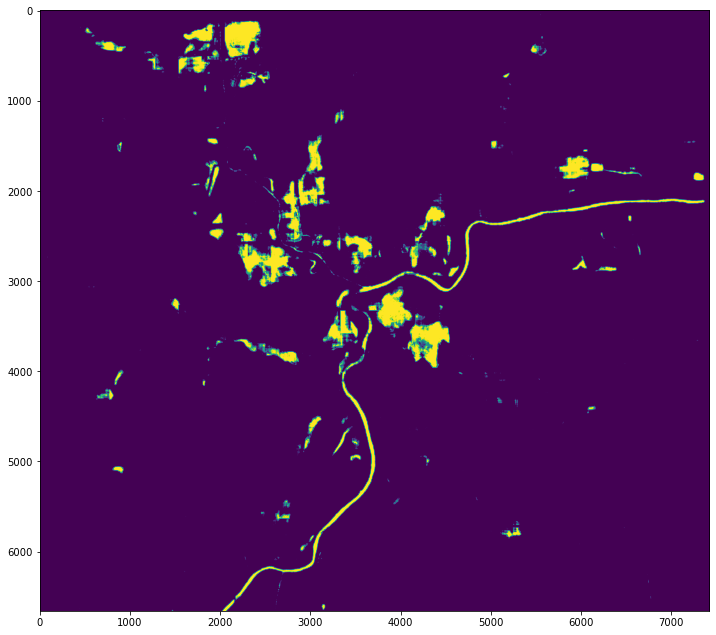

In [35]:
# We can visualize the predictions here in the notebook
from matplotlib import pyplot as plt
from matplotlib import colors

figure = plt.figure(figsize = (12,12))
# cmap = colors.ListedColormap(['#5dc5f1', '#50a886', '#3d6e1d', '#80e144', '#bafb85', '#d4a13e', "#e73522", "#9c9c9c", "#000000", "#706e22", "#e7e64b", "#fefc86", '#ad36ed'])
prob = preds[:, :, 0]
# cls = out_image[:, :, 0]

plt.imshow(prob)#, norm = colors.BoundaryNorm([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], cmap.N), cmap = cmap)

In [ ]:
!pip install folium

In [22]:
!pip install earthengine-api --upgrade

     |████████████████████████████████| 241 kB 29.6 MB/s eta 0:00:01
     |████████████████████████████████| 106 kB 84.1 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 719 kB/s  eta 0:00:01
     |████████████████████████████████| 96 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 76 kB 5.7 MB/s  eta 0:00:01
     |████████████████████████████████| 114 kB 90.6 MB/s eta 0:00:01
     |████████████████████████████████| 211 kB 95.2 MB/s eta 0:00:01
  Created wheel for earthengine-api: filename=earthengine_api-0.1.316-py3-none-any.whl size=270124 sha256=7f201ace9b9328dc42a4c3271af9c906bb3dafc16ffd6959f7d8fb54b8ac2ecb
  Stored in directory: /home/azureuser/.cache/pip/wheels/82/33/8e/a13580cec1632b65e46f745b802fcee1a445d2a416216c86f6
  Created wheel for httplib2shim: filename=httplib2shim-0.0.3-py2.py3-none-any.whl size=18056 sha256=89767bacf3079ddbb1365b91b49bcf73e9bcd3565af6243d79af1a42794a1103
  Stored in directory: /home/azureuser/.cache/pip/wheels/50/6c/00/

In [23]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [19]:
# Folium setup.
import folium
print(folium.__version__)

# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

0.12.1.post1


In [39]:
import rasterio.warp
from rasterio.crs import CRS
from rasterio.transform import array_bounds
transform = mixData['projection']['affine']['doubleMatrix']
print(transform)
src_crs = CRS.from_string(mixData['projection']['crs'])
print(src_crs)
affine = rio.Affine(transform[0], transform[1], transform[2], transform[3], transform[4], transform[5])
H,W = [0,0]

if type(prob) == np.ndarray:
    print('input image is numpy')
    H,W = prob.shape
    print('image shape is ', H, W)
    bounds = array_bounds(H, W, affine)

lon_min, lat_min, lon_max, lat_max = bounds
# if we need to transform the bounds, such as for folium ('EPSG:3857')

print([[lat_min, lon_min], [lat_max, lon_max]])

[1.0, 0.0, 693231.0, 0.0, -1.0, 4530872.0]
EPSG:26914
input image is numpy
image shape is  6656 7424
[[4524216.0, 693231.0], [4530872.0, 700655.0]]


In [41]:
# Project the feature to the desired CRS
feature = {
    "type": "Polygon",
    "coordinates": [
       [[lon_max, lat_min], 
        [lon_max, lat_max], 
        [lon_min, lat_max], 
        [lon_min, lat_min], 
        [lon_max, lat_min]]
   ]
}

feature_proj = rasterio.warp.transform_geom(
    CRS.from_epsg(26914),
    CRS.from_epsg(4326),
    feature
)

In [45]:
feature_proj['coordinates']

[[(-96.61982137773505, 40.84444648524924),
  (-96.61767359283405, 40.90435474445901),
  (-96.70574817577686, 40.90614146346636),
  (-96.70781672995143, 40.846229457458975),
  (-96.61982137773505, 40.84444648524924)]]

19



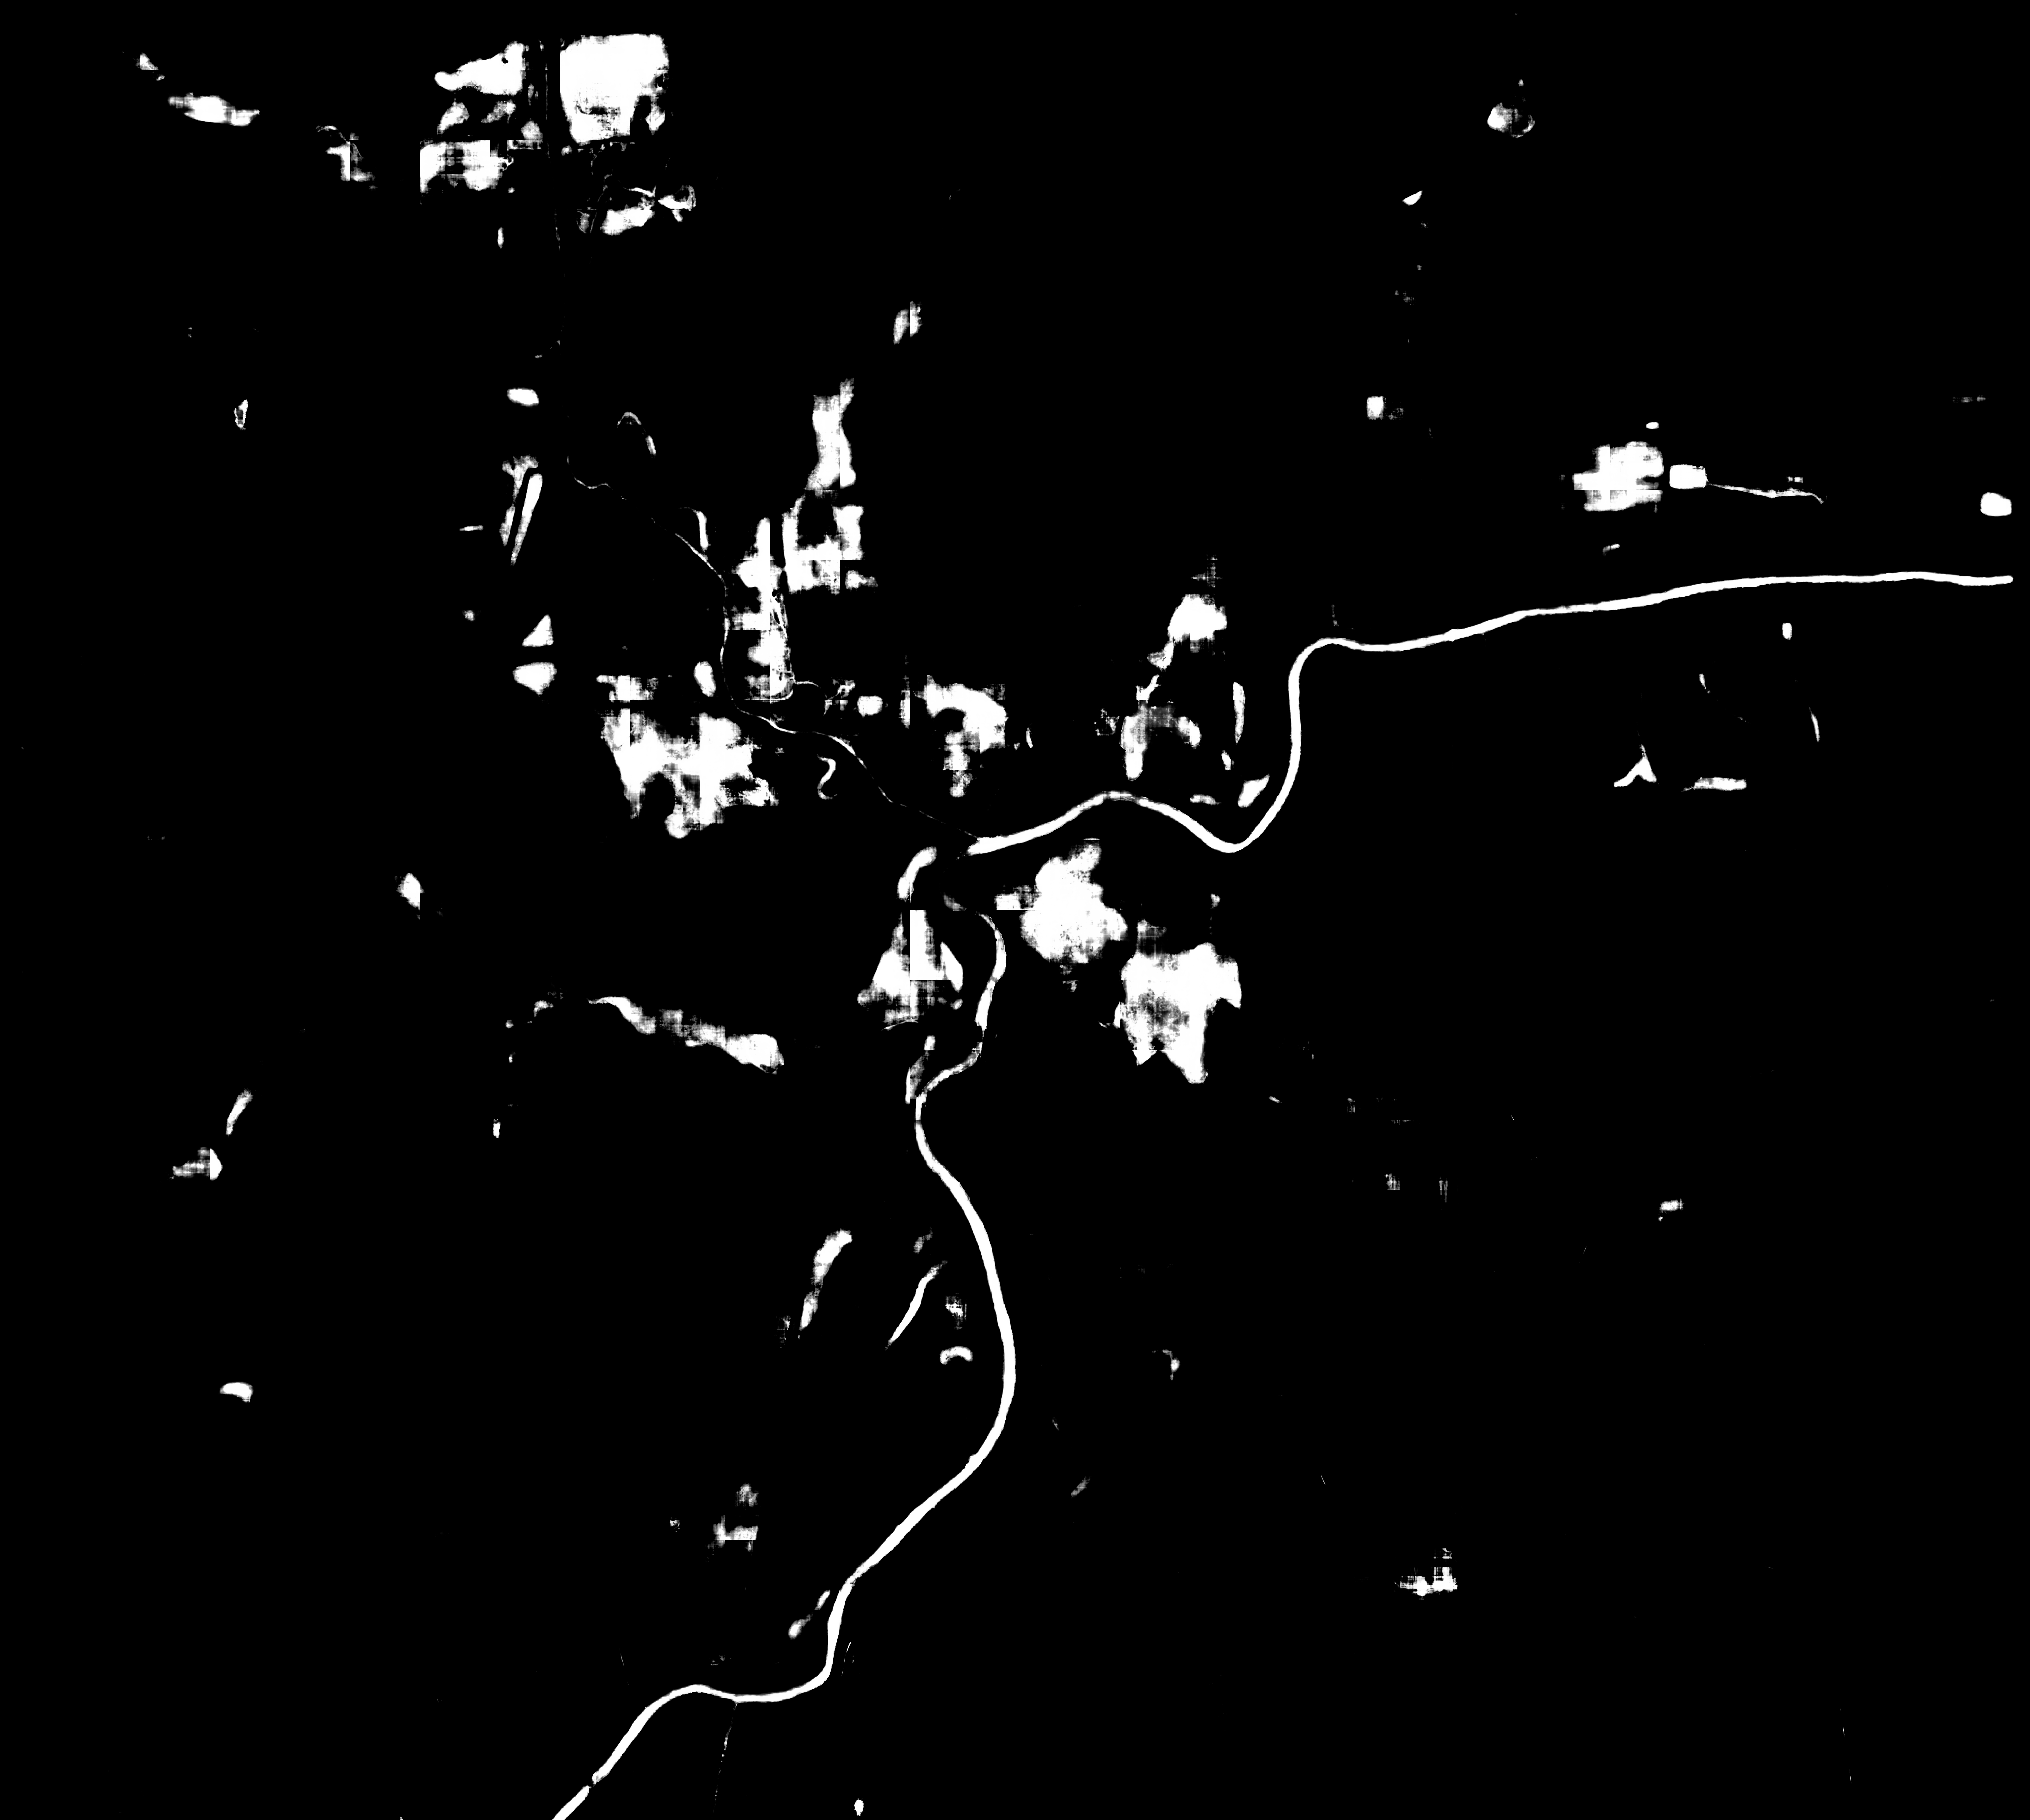

In [46]:
S2 = ee.ImageCollection("COPERNICUS/S2_SR")
aoi = ee.Geometry.Rectangle([-96.70574817577686, 40.84444648524924, -96.61982137773505, 40.90614146346636])
# define various filters
cloudFilter = ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 10)
dateFilter = ee.Filter.date('2022-04-01', '2022-07-01')
roiFilter = ee.Filter.bounds(aoi)

s2Filter = ee.Filter.And(dateFilter, roiFilter, cloudFilter)

s2 = S2.filter(s2Filter)
print(s2.size().getInfo())
# Create a simple median composite to visualize
s2Summer = s2.mosaic().select(['B2', 'B3', 'B4'])

m = folium.Map([43.14177, -75.769], zoom_start = 8)
img = folium.raster_layers.ImageOverlay(
    name = 'predictions',
    image = prob,
    bounds = [[40.84444648524924, -96.70574817577686], [40.90614146346636, -96.61982137773505]]
)

m.add_ee_layer(s2Summer, {'bands':['B4', 'B3', 'B2'], 'min':250, 'max':3000}, 'S2')
img.add_to(m)
folium.LayerControl().add_to(m)
m

In [27]:
write_geotiff_predictions(predFiles, m, jsonFile[0], BANDS, 50, 'MN_test_basic', './', export = False)

Downloaded path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/data/predict/test_aoi_David2_MN/raw_unet256_test_aoi_David2_MNmixer.json is different from target path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/raw_unet256_test_aoi_David2_MNmixer.json
Downloaded path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/data/predict/test_aoi_David2_MN/raw_unet256_test_aoi_David2_MN00000.tfrecord.gz is different from target path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/raw_unet256_test_aoi_David2_MN00000.tfrecord.gz
Downloaded path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/data/predict/test_aoi_David2_MN/raw_unet256_test_aoi_David2_MN00001.tfrecord.gz is different from target path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/raw_unet256_test_aoi_David2_MN00001.tfrecord.gz
Downloaded path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/data/predict/test_aoi_David2_MN/raw_unet256_test_aoi_David2_MN00002.tfrecord.gz is differen

In [19]:
%cd ..

/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsbasiccpu/code/Users/mevans


In [22]:
write_geotiff_prediction(
    prob,
    '/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsbasiccpu/code/Users/mevans/raw_unet256_greenburymixer.json',
    'greenbury_basic_seasonal')

## Predict using submitted run

In [50]:
# create script run config
# use the azure folder as our script folder

script_folder = 'azure'
script_file = 'predict_wetland.py'

In [51]:
env = ws.environments['wetland-training']
compute = ws.compute_targets['wetlandsGPU']
experiment_name = 'wetland-unet-predict'
exp = Experiment(workspace = ws, name = experiment_name) 

In [52]:
# define the command line arguments to our training sript
mod = 'seasonal-full'
args = [
    '--data_dir', test_dataset.as_mount(),
    '--model_id', f'wetland-unet-{mod}',
    '--aoi', aoi]

In [54]:
#  run the training job
src = ScriptRunConfig(source_directory=script_folder,
                      script=script_file, 
                      arguments=args,
                      compute_target=compute,
                      environment=env)
run = exp.submit(config=src, tags = {'aoi':f'{aoi}', 'model':f'{mod}'})
run

Run(Experiment: wetland-unet-predict,
Id: wetland-unet-predict_1661779123_7c31a4bb,
Type: azureml.scriptrun,
Status: Queued)

## Let's look at the predictions made by our submitted jobs

In [2]:
import rasterio as rio


In [24]:
run.download_file(name = 'outputs/aoi_LES_entire_basic.tif', output_file_path = './Users/mevans/LES.tif')

In [25]:
with rio.open('./Users/mevans/LES.tif') as src:
    preds = src.read()
    shp = src.shape

In [26]:
preds.max()

1.0

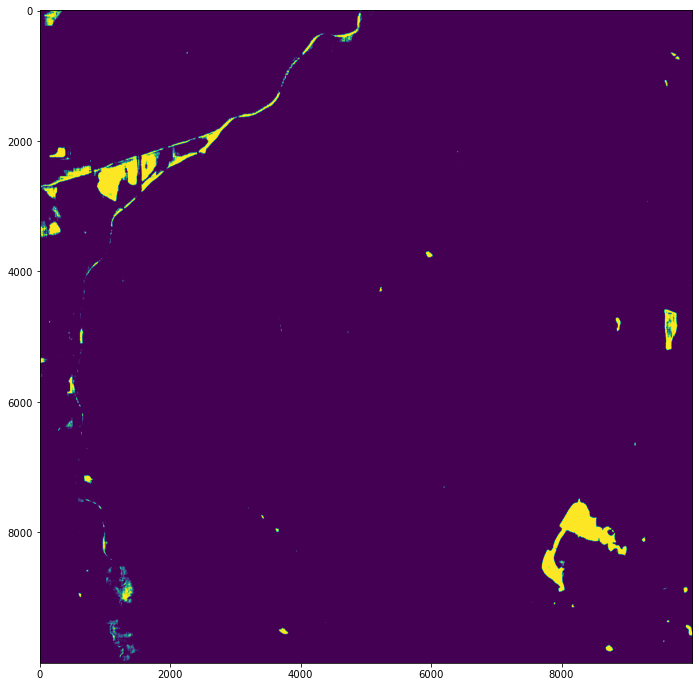

In [27]:
# We can visualize the predictions here in the notebook
from matplotlib import pyplot as plt
from matplotlib import colors

figure = plt.figure(figsize = (12,12))
# cmap = colors.ListedColormap(['#5dc5f1', '#50a886', '#3d6e1d', '#80e144', '#bafb85', '#d4a13e', "#e73522", "#9c9c9c", "#000000", "#706e22", "#e7e64b", "#fefc86", '#ad36ed'])
prob = preds[0, 10000:20000, 10000:20000]
# cls = out_image[:, :, 0]

plt.imshow(prob)#, norm = colors.BoundaryNorm([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], cmap.N), cmap = cmap)